<a href="http://landlab.github.io"><img style="float: left; height: 175px; width: 175px" src="./landlab_logo.jpg"></a> <h3 style="margin: 117px 0 0 185px; font-weight: 300;">a toolkit for modeling earth surface processes</h3>

# Using the KinwaveImplicitOverlandFlow and OverlandFlow components to map flow over a catchment

<hr>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

This tutorial illustrates the use of both the KinwaveImplicitOverlandFlow component and the OverlandFlow component to map flow over a catchment. It serves as a comparison between the two methods being used to solve the shallow water equation:

$$ \frac{\partial Q}{\partial t} + \frac{\partial}{\partial x}\left(\frac{Q^2}{A_{xs}}\right) + gA_{xs} \frac{\partial (h+z)}{\partial x} + \frac{gn^2 \lvert{Q}\rvert Q}{R^{4/3}A_{xs}} = 0 \space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space(1)$$
    


where      
&nbsp;&nbsp;&nbsp;&nbsp;$Q = discharge \left[L^3{T^{-1}}\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$t = time \left[T\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$x = location \space in \space space \left[L\right]$   
&nbsp;&nbsp;&nbsp;&nbsp;$g = acceleration \space due \space to \space gravity \left[L{T^{-2}}\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$h = water \space depth \left[L\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$z = bed \space elevation \left[L\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$n = Manning's \space roughness \space coeffiecient \left[T{L^{{-1}/{3}}}\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$R = hydraulic \space radius \left[L\right]$  
&nbsp;&nbsp;&nbsp;&nbsp;$A_{xs} = cross-sectional \space area \left[L^2\right]$ 

From left to right in Equation 1, these terms represent the local acceleration, advection, fluid pressure, and friction slope. Because this equation is difficult (i.e., almost impossible) to solve explicitly, approximations are commonly used. In the kinematic wave approximation used in KinwaveImplicitOverlandFlow, all terms are neglected except for the friction slope term, making this the simplest approximation. In the approximation used in OverlandFlow, only the advection term is neglected, and the geometry of the channels is assumed to be rectangular and of constant flow width (Adams et al. 2017). The approximation used in OverlandFlow is more accurate but also more computationally expensive than the approximation used in KinwaveImplicitOverlandFlow.

The catchment used in this tutorial is the Spring Creek watershed, a steep 27 km$^2$ watershed located in central Colorado. The DEM we will use has a resolution of 30 meters (Adams et al. 2017). We will be running our model for 6 hours with a storm at the beginning that lasts 2 hours. We will look at what our hydrographs at the outlet of our watershed look like, as well as what the water depth of our catchment looks like over time.

First, import what we'll need:

In [1]:
from landlab.components.overland_flow import KinwaveImplicitOverlandFlow, OverlandFlow  #import necessary Landlab components

from landlab.plot.imshow import imshow_grid                                             #import some Landlab utilities
from landlab.plot.colors import water_colormap
from landlab import RasterModelGrid
from landlab.io.esri_ascii import read_esri_ascii

import matplotlib.pyplot as plt                                                         #import other Python packages
import numpy as np
from time import time

%matplotlib inline

Now, we'll pick the initial and run conditions:

In [2]:
model_run_time = 6                     # duration of model run, (hr)
storm_duration = 2                     # duration of storm, (hr)
elapsed_time = 0                       # model starts running at t = 0 seconds
rainfall_intensity = 15                # typical rainstorm intensity in this watershed, (mm/hr)
hydrograph_time = []                   # an empty array to be used to hold the time axis for the hydrograph
discharge_at_outlet = []               # an empty array to be used to hold the discharge axis for the hydrograph
n = 0.03                               # Manning's roughness coefficient, (s/m^(1/3))
dt = 600                               # time step for KinwaveImplicitOverlandFlow, (s) [i.e., 10 minutes]

Next, we'll use Landlab's read_esri_ascii function to import the DEM of the catchment which we will be working with. This function allows us to read in both the shape of the grid and topographic data of the catchment.

In [3]:
mg, z = read_esri_ascii('SpringCreek_DEM.asc', name = 'topographic__elevation') # read in the ascii file
mg.set_watershed_boundary_condition(z, nodata_value=-9999)

The boundary conditions for this grid were set with the final line above, but in order to ensure that our flow is drained to a single point, we need to set our outlet node.

In [4]:
outlet_id = mg.core_nodes[np.argmin(mg.at_node['topographic__elevation'][mg.core_nodes])] # what is the lowest point on our DEM?            
mg.set_watershed_boundary_condition_outlet_id(outlet_id, z)                               # set the lowest point as the outlet

print(outlet_id)                                                   # print outlet id number
print(mg.at_node['topographic__elevation'][outlet_id])             # print elevation of outlet node
print(np.min(mg.at_node['topographic__elevation'][mg.core_nodes])) # print minimum elevation of core nodes
print(np.max(mg.at_node['topographic__elevation'][mg.core_nodes])) # print maximum elevation of core nodes

55744
1876.86
1878.37
2611.011


With everything initialized, let's look at our watershed topography.

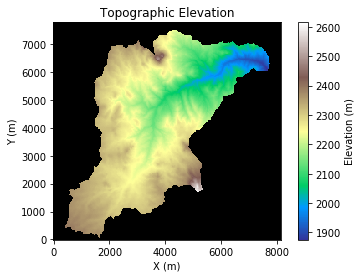

In [5]:
imshow_grid(mg,'topographic__elevation', plot_name = 'Topographic Elevation', 
            var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'), 
            cmap = 'terrain', limits = (1875, 2615))
plt.show()

Now we can begin to instantiate our components. We'll start with KinwaveImplicitOverlandFlow because it is the more "basic" of the two components. The main parameters to define in KinwaveImplicitOverlandFlow are as follows: 
  
**grid**: ModelGrid  
&nbsp;&nbsp;&nbsp;&nbsp;Landlab ModelGrid object  
**runoff_rate**: float, optional (defaults to 1 mm/hr)  
&nbsp;&nbsp;&nbsp;&nbsp;Precipitation rate, mm/hr  
**roughness**: float, defaults to 0.01  
&nbsp;&nbsp;&nbsp;&nbsp;Manning roughness coefficient, s/m$^{1/3}$   
**changing_topo**: boolean, optional (defaults to False)  
&nbsp;&nbsp;&nbsp;&nbsp;Flag indicating whether topography changes between time steps  
**depth_exp**: float (defaults to 1.5)  
&nbsp;&nbsp;&nbsp;&nbsp;Exponent on water depth in velocity equation (3/2 for Darcy/Chezy, 5/3 for Manning)  
**weight**: float (defaults to 1.0)  
&nbsp;&nbsp;&nbsp;&nbsp;Weighting on depth at new time step versus old time step (1 = all implicit; 0 = explicit)
        
In the case of this tutorial, we will only be defining the grid, roughness, and depth_exp (using 5/3 for Manning's equation). We will also define the runoff_rate with different values, but that will occur in the component driver.

In [6]:
kw = KinwaveImplicitOverlandFlow(mg, runoff_rate = 0.0, roughness = n, depth_exp = 5/3)

After initializing, we can run our component driver using a simple while loop. In words, the below driver does the following:   
While the elapsed time is less than or equal to the total model run time, loop through the next statements.  
&nbsp;&nbsp;&nbsp;&nbsp;1) If the elapsed time is less than the storm duration, run the component using a rainfall intensity of 5 mm/hr.  
&nbsp;&nbsp;&nbsp;&nbsp;2) If the elapsed time is greater than the storm duration, run the component using a rainfall intensity of 0 mm/hr.  
&nbsp;&nbsp;&nbsp;&nbsp;3) Determine the discharge that flows through the outlet node at the current elapsed time.  
&nbsp;&nbsp;&nbsp;&nbsp;4) Update the arrays with values of the time and discharge at outlet for plotting purposes.  
&nbsp;&nbsp;&nbsp;&nbsp;5) Increase the elapsed time by the time step.


In [7]:
while elapsed_time <= model_run_time*3600:
    if elapsed_time < storm_duration*3600:
        kw.run_one_step(dt, current_time = elapsed_time, runoff_rate = rainfall_intensity*2.77778e-7)
    else:
        kw.run_one_step(dt, current_time = elapsed_time, runoff_rate = 0.0)
    
    q_at_outlet = mg.at_node['surface_water_inflow__discharge'][outlet_id]

    hydrograph_time.append(elapsed_time/3600.)
    discharge_at_outlet.append(q_at_outlet)

    elapsed_time += dt
    print("Elapsed time = %i minutes" %(elapsed_time/60))

Elapsed time = 10 minutes
Elapsed time = 20 minutes
Elapsed time = 30 minutes
Elapsed time = 40 minutes
Elapsed time = 50 minutes
Elapsed time = 60 minutes
Elapsed time = 70 minutes
Elapsed time = 80 minutes
Elapsed time = 90 minutes
Elapsed time = 100 minutes
Elapsed time = 110 minutes
Elapsed time = 120 minutes
Elapsed time = 130 minutes
Elapsed time = 140 minutes
Elapsed time = 150 minutes
Elapsed time = 160 minutes
Elapsed time = 170 minutes
Elapsed time = 180 minutes
Elapsed time = 190 minutes
Elapsed time = 200 minutes
Elapsed time = 210 minutes
Elapsed time = 220 minutes
Elapsed time = 230 minutes
Elapsed time = 240 minutes
Elapsed time = 250 minutes
Elapsed time = 260 minutes
Elapsed time = 270 minutes
Elapsed time = 280 minutes
Elapsed time = 290 minutes
Elapsed time = 300 minutes
Elapsed time = 310 minutes
Elapsed time = 320 minutes
Elapsed time = 330 minutes
Elapsed time = 340 minutes
Elapsed time = 350 minutes
Elapsed time = 360 minutes
Elapsed time = 370 minutes


And plot the outlet hydrograph (i.e., discharge vs. time at the outlet node) to see the changes in flow over time, as well as the water depth over the whole area at the final time step:

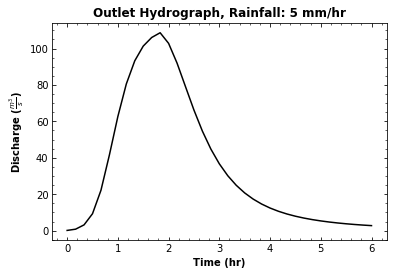

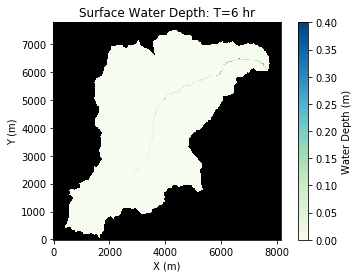

In [8]:
plt.figure(1)
ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in', bottom=True, left=True, top=True, right=True)
plt.minorticks_on()
plt.plot(hydrograph_time, discharge_at_outlet, 'k-')
plt.xlabel('Time (hr)', fontweight = 'bold')
plt.ylabel(r'Discharge ($\frac{m^3}{s}$)', fontweight = 'bold')
plt.title('Outlet Hydrograph, Rainfall: 5 mm/hr', fontweight = 'bold')
plt.show()

plt.figure(2)
imshow_grid(mg, 'surface_water__depth', plot_name = 'Surface Water Depth: T=%i hr'%(elapsed_time/3600), 
            var_name = 'Water Depth', var_units = 'm', grid_units = ('m','m'), 
            cmap='GnBu', limits = (0, 0.4))
plt.show()

We can also look at the water depths of the area at different timesteps. The driver below is similar to what we did above, but this time, we loop through the different time slices in a variable t to get water depth plots at those different time steps.  

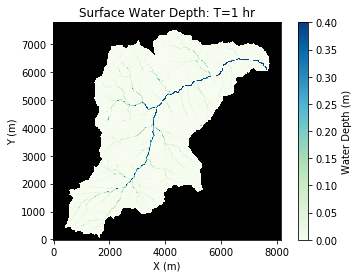

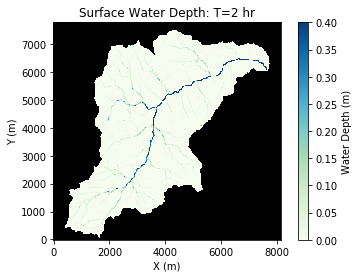

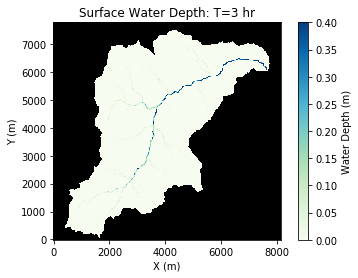

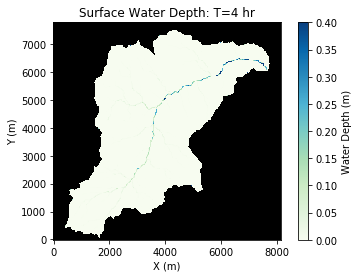

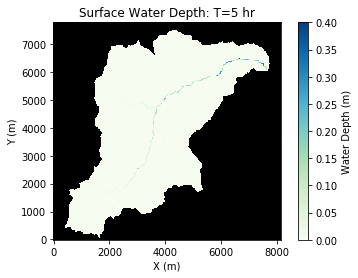

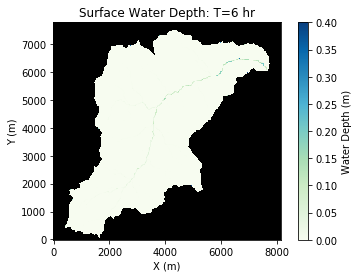

In [9]:
elapsed_time = 0              # re-initialize elapsed_time
t = (1, 2, 3, 4, 5, 6)        # time slices for water depth plots, (hr)
t_sec = np.multiply(t, 3600)  # time slices for water depth plots, (sec)

for time in t_sec: 
    while elapsed_time < time:
        if elapsed_time < storm_duration*3600:
            kw.run_one_step(dt, current_time = elapsed_time, runoff_rate = rainfall_intensity*2.77778e-7)
        else:
            kw.run_one_step(dt, current_time = elapsed_time, runoff_rate = 0.0)
     
        elapsed_time += dt       
    
    plt.figure(time/3600)
    imshow_grid(mg, 'surface_water__depth', plot_name = 'Surface Water Depth: T=%i hr' %(time/3600), 
                var_name = 'Water Depth', var_units = 'm', grid_units = ('m','m'), 
                cmap='GnBu', limits = (0, 0.4))
    plt.show()

Now that we've run the KinwaveImplicitOverlandFlow component, we can take the same process and apply that to the OverlandFlow component to see how the two compare. First, we'll re-initialize parameters that were altered in the previous steps:

In [10]:
elapsed_time = 0                       # model starts running at t = 0 sec
hydrograph_time = []                   # an empty array to be used to hold the time axis for the hydrograph
discharge_at_outlet = []               # an empty array to be used to hold the discharge axis for the hydrograph

And re-load our DEM and plot it. This is to ensure that Python doesn't get confused and start producing errors and/or wacky results.

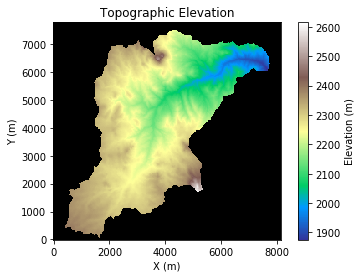

In [11]:
mg, z = read_esri_ascii('SpringCreek_DEM.asc', name = 'topographic__elevation') # read in the ascii file
mg.set_watershed_boundary_condition(z, nodata_value=-9999)

outlet_id = mg.core_nodes[np.argmin(mg.at_node['topographic__elevation'][mg.core_nodes])] # what is the lowest point on our DEM?            
mg.set_watershed_boundary_condition_outlet_id(outlet_id, z)                               # set the lowest point as the outlet

imshow_grid(mg,'topographic__elevation', plot_name = 'Topographic Elevation', 
            var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'), 
            cmap = 'terrain', limits = (1875, 2615))
plt.show()

Next, we can instantiate and run the OverlandFlow component. One interesting thing to note about this component is that it uses an adaptive timestep based on the surface water depth. The main parameters to define in OverlandFlow are as follows:  

**grid**: RasterModelGrid  
&nbsp;&nbsp;&nbsp;&nbsp;A landlab grid.  
**h_init**: float, optional  
&nbsp;&nbsp;&nbsp;&nbsp;Thickness of initial thin layer of water to prevent divide by zero errors (m).  
**alpha**: float, optional  
&nbsp;&nbsp;&nbsp;&nbsp;Time step coeffcient, described in Bates et al., 2010 and de Almeida et al., 2012.  
**mannings_n**: float, optional  
&nbsp;&nbsp;&nbsp;&nbsp;Manning's roughness coefficient.  
**g**: float, optional  
&nbsp;&nbsp;&nbsp;&nbsp;Acceleration due to gravity (m/s^2).  
**theta**: float, optional  
&nbsp;&nbsp;&nbsp;&nbsp;Weighting factor from de Almeida et al., 2012.  
**rainfall_intensity**: float, optional  
&nbsp;&nbsp;&nbsp;&nbsp;Rainfall intensity.  
**steep_slopes**: boolean, optional  
&nbsp;&nbsp;&nbsp;&nbsp;To ensure the water isn't draining too fast for the time step.

In the case of this tutorial, we will only be defining the grid, mannings_n and steep_slopes. We will also define the rainfall_intensity, but that will occur in the component driver. 

In words, the driver below the component instantiation does the following:  
While the elapsed time is less than or equal to the total model run time, loop through the next statements.  
&nbsp;&nbsp;&nbsp;&nbsp;1) Calculate the adaptive time step for the current time.  
&nbsp;&nbsp;&nbsp;&nbsp;2) If the elapsed time is less than the storm duration, run the component using a rainfall intensity of 5 mm/hr.  
&nbsp;&nbsp;&nbsp;&nbsp;3) If the elapsed time is greater than the storm duration, run the component using a rainfall intensity of 0 mm/hr.  
&nbsp;&nbsp;&nbsp;&nbsp;4) Map the surface water discharge onto the nodes.  
&nbsp;&nbsp;&nbsp;&nbsp;5) Determine the discharge that flows through the outlet node at the current elapsed time.  
&nbsp;&nbsp;&nbsp;&nbsp;6) Update the arrays with values of the time and discharge at outlet for plotting purposes.  
&nbsp;&nbsp;&nbsp;&nbsp;7) Increase the elapsed time by the adaptive time step.

In [12]:
of = OverlandFlow(mg, mannings_n = n, steep_slopes = True)

while elapsed_time <= model_run_time*3600:
    of.delta_t = of.calc_time_step()
    if elapsed_time < storm_duration*3600:
        of.rainfall_intensity = rainfall_intensity*2.77778e-7
    else:
        of.rainfall_intensity = 0.0
    of.overland_flow()
    
    mg.at_node['surface_water__discharge'] = of.discharge_mapper(of.q, convert_to_volume = True)
    q_at_outlet = mg.at_node['surface_water__discharge'][outlet_id]

    hydrograph_time.append(elapsed_time/3600.)
    discharge_at_outlet.append(q_at_outlet)
                                   
    elapsed_time += of.delta_t
    print("Elapsed time = %i minutes" %(elapsed_time/60))

Elapsed time = 35 minutes
Elapsed time = 36 minutes
Elapsed time = 37 minutes
Elapsed time = 38 minutes
Elapsed time = 38 minutes
Elapsed time = 39 minutes
Elapsed time = 40 minutes
Elapsed time = 40 minutes
Elapsed time = 41 minutes
Elapsed time = 41 minutes
Elapsed time = 41 minutes
Elapsed time = 42 minutes
Elapsed time = 42 minutes
Elapsed time = 43 minutes
Elapsed time = 43 minutes
Elapsed time = 43 minutes
Elapsed time = 44 minutes
Elapsed time = 44 minutes
Elapsed time = 44 minutes
Elapsed time = 45 minutes
Elapsed time = 45 minutes
Elapsed time = 45 minutes
Elapsed time = 46 minutes
Elapsed time = 46 minutes
Elapsed time = 46 minutes
Elapsed time = 46 minutes
Elapsed time = 47 minutes
Elapsed time = 47 minutes
Elapsed time = 47 minutes
Elapsed time = 47 minutes
Elapsed time = 48 minutes
Elapsed time = 48 minutes
Elapsed time = 48 minutes
Elapsed time = 48 minutes
Elapsed time = 49 minutes
Elapsed time = 49 minutes
Elapsed time = 49 minutes
Elapsed time = 49 minutes
Elapsed time

Elapsed time = 86 minutes
Elapsed time = 86 minutes
Elapsed time = 86 minutes
Elapsed time = 86 minutes
Elapsed time = 86 minutes
Elapsed time = 86 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 87 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 88 minutes
Elapsed time = 89 minutes
Elapsed time = 89 minutes
Elapsed time = 89 minutes
Elapsed time = 89 minutes
Elapsed time = 89 minutes
Elapsed time = 89 minutes
Elapsed time = 89 minutes
Elapsed time

Elapsed time = 109 minutes
Elapsed time = 109 minutes
Elapsed time = 109 minutes
Elapsed time = 109 minutes
Elapsed time = 109 minutes
Elapsed time = 109 minutes
Elapsed time = 109 minutes
Elapsed time = 109 minutes
Elapsed time = 109 minutes
Elapsed time = 109 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 110 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
Elapsed time = 111 minutes
E

Elapsed time = 129 minutes
Elapsed time = 129 minutes
Elapsed time = 129 minutes
Elapsed time = 129 minutes
Elapsed time = 129 minutes
Elapsed time = 129 minutes
Elapsed time = 129 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 130 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
Elapsed time = 131 minutes
E

Elapsed time = 148 minutes
Elapsed time = 148 minutes
Elapsed time = 148 minutes
Elapsed time = 148 minutes
Elapsed time = 148 minutes
Elapsed time = 148 minutes
Elapsed time = 148 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 149 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
Elapsed time = 150 minutes
E

Elapsed time = 168 minutes
Elapsed time = 168 minutes
Elapsed time = 168 minutes
Elapsed time = 168 minutes
Elapsed time = 168 minutes
Elapsed time = 168 minutes
Elapsed time = 168 minutes
Elapsed time = 168 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 169 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
Elapsed time = 170 minutes
E

Elapsed time = 189 minutes
Elapsed time = 189 minutes
Elapsed time = 189 minutes
Elapsed time = 189 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 190 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 191 minutes
Elapsed time = 192 minutes
Elapsed time = 192 minutes
Elapsed time = 192 minutes
Elapsed time = 192 minutes
Elapsed time = 192 minutes
Elapsed time = 192 minutes
E

Elapsed time = 215 minutes
Elapsed time = 215 minutes
Elapsed time = 215 minutes
Elapsed time = 215 minutes
Elapsed time = 215 minutes
Elapsed time = 215 minutes
Elapsed time = 215 minutes
Elapsed time = 215 minutes
Elapsed time = 215 minutes
Elapsed time = 215 minutes
Elapsed time = 216 minutes
Elapsed time = 216 minutes
Elapsed time = 216 minutes
Elapsed time = 216 minutes
Elapsed time = 216 minutes
Elapsed time = 216 minutes
Elapsed time = 216 minutes
Elapsed time = 216 minutes
Elapsed time = 216 minutes
Elapsed time = 216 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 217 minutes
Elapsed time = 218 minutes
Elapsed time = 218 minutes
Elapsed time = 218 minutes
Elapsed time = 218 minutes
Elapsed time = 218 minutes
Elapsed time = 218 minutes
E

Elapsed time = 246 minutes
Elapsed time = 246 minutes
Elapsed time = 247 minutes
Elapsed time = 247 minutes
Elapsed time = 247 minutes
Elapsed time = 247 minutes
Elapsed time = 247 minutes
Elapsed time = 247 minutes
Elapsed time = 247 minutes
Elapsed time = 247 minutes
Elapsed time = 247 minutes
Elapsed time = 248 minutes
Elapsed time = 248 minutes
Elapsed time = 248 minutes
Elapsed time = 248 minutes
Elapsed time = 248 minutes
Elapsed time = 248 minutes
Elapsed time = 248 minutes
Elapsed time = 248 minutes
Elapsed time = 249 minutes
Elapsed time = 249 minutes
Elapsed time = 249 minutes
Elapsed time = 249 minutes
Elapsed time = 249 minutes
Elapsed time = 249 minutes
Elapsed time = 249 minutes
Elapsed time = 249 minutes
Elapsed time = 250 minutes
Elapsed time = 250 minutes
Elapsed time = 250 minutes
Elapsed time = 250 minutes
Elapsed time = 250 minutes
Elapsed time = 250 minutes
Elapsed time = 250 minutes
Elapsed time = 250 minutes
Elapsed time = 250 minutes
Elapsed time = 251 minutes
E

Elapsed time = 285 minutes
Elapsed time = 285 minutes
Elapsed time = 285 minutes
Elapsed time = 285 minutes
Elapsed time = 285 minutes
Elapsed time = 285 minutes
Elapsed time = 285 minutes
Elapsed time = 285 minutes
Elapsed time = 286 minutes
Elapsed time = 286 minutes
Elapsed time = 286 minutes
Elapsed time = 286 minutes
Elapsed time = 286 minutes
Elapsed time = 286 minutes
Elapsed time = 286 minutes
Elapsed time = 286 minutes
Elapsed time = 287 minutes
Elapsed time = 287 minutes
Elapsed time = 287 minutes
Elapsed time = 287 minutes
Elapsed time = 287 minutes
Elapsed time = 287 minutes
Elapsed time = 287 minutes
Elapsed time = 287 minutes
Elapsed time = 288 minutes
Elapsed time = 288 minutes
Elapsed time = 288 minutes
Elapsed time = 288 minutes
Elapsed time = 288 minutes
Elapsed time = 288 minutes
Elapsed time = 288 minutes
Elapsed time = 288 minutes
Elapsed time = 289 minutes
Elapsed time = 289 minutes
Elapsed time = 289 minutes
Elapsed time = 289 minutes
Elapsed time = 289 minutes
E

Elapsed time = 323 minutes
Elapsed time = 323 minutes
Elapsed time = 323 minutes
Elapsed time = 324 minutes
Elapsed time = 324 minutes
Elapsed time = 324 minutes
Elapsed time = 324 minutes
Elapsed time = 324 minutes
Elapsed time = 324 minutes
Elapsed time = 324 minutes
Elapsed time = 324 minutes
Elapsed time = 325 minutes
Elapsed time = 325 minutes
Elapsed time = 325 minutes
Elapsed time = 325 minutes
Elapsed time = 325 minutes
Elapsed time = 325 minutes
Elapsed time = 325 minutes
Elapsed time = 325 minutes
Elapsed time = 326 minutes
Elapsed time = 326 minutes
Elapsed time = 326 minutes
Elapsed time = 326 minutes
Elapsed time = 326 minutes
Elapsed time = 326 minutes
Elapsed time = 326 minutes
Elapsed time = 326 minutes
Elapsed time = 327 minutes
Elapsed time = 327 minutes
Elapsed time = 327 minutes
Elapsed time = 327 minutes
Elapsed time = 327 minutes
Elapsed time = 327 minutes
Elapsed time = 327 minutes
Elapsed time = 327 minutes
Elapsed time = 328 minutes
Elapsed time = 328 minutes
E

Now, we can look at the outlet hydrograph (i.e., discharge vs. time at the outlet node) to see the changes in flow over time, and water depth at the final timestep and compare these to those of KinwaveImplicitOverlandFlow:

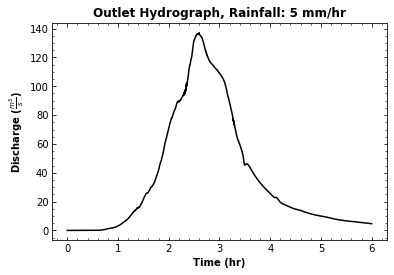

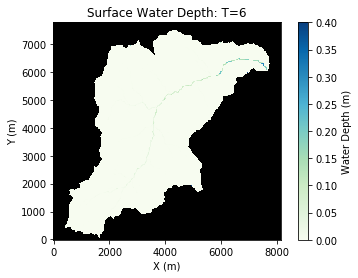

In [13]:
plt.figure(1)
ax = plt.gca()
ax.tick_params(axis='both', which='both', direction='in', bottom=True, left=True, top=True, right=True)
plt.minorticks_on()
plt.plot(hydrograph_time, discharge_at_outlet, 'k-')
plt.xlabel('Time (hr)', fontweight = 'bold')
plt.ylabel(r'Discharge ($\frac{m^3}{s}$)', fontweight = 'bold')
plt.title('Outlet Hydrograph, Rainfall: 5 mm/hr', fontweight = 'bold')
plt.show()

plt.figure(2)
imshow_grid(mg, 'surface_water__depth', plot_name = 'Surface Water Depth: T=%i' %(elapsed_time/3600), 
            var_name = 'Water Depth', var_units = 'm', grid_units = ('m','m'), 
            cmap='GnBu', limits = (0, 0.4))
plt.show()

We can also look at the water depths of the area at different timesteps and compare to those of KinwaveImplicitOverlandFlow. The driver below is similar to what we did above, but this time, we loop through the different time slices in our variable t to get water depth plots at those different time steps.

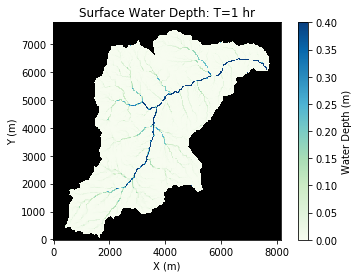

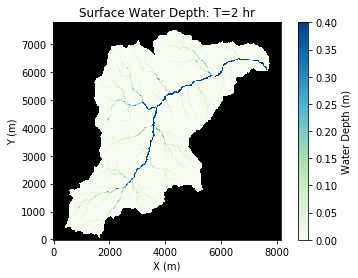

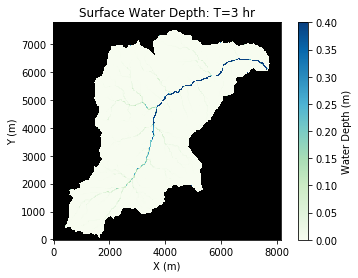

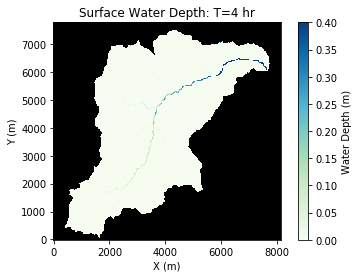

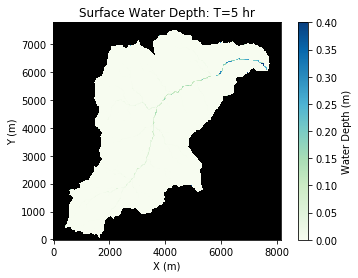

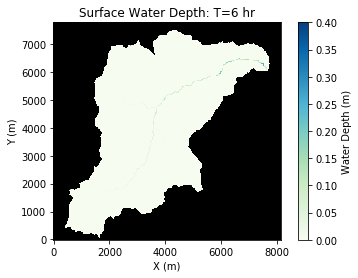

In [14]:
elapsed_time = 0 #re-initialize elapsed_time
t = (1, 2, 3, 4, 5, 6)
t_sec = np.multiply(t, 3600)

for time in t_sec: 
    while elapsed_time < time:
        of.delta_t = of.calc_time_step()
        if elapsed_time < storm_duration*3600:
            of.rainfall_intensity = rainfall_intensity*2.77778e-7
        else:
            of.rainfall_intensity = 0.0
        of.overland_flow()
    
        mg.at_node['surface_water__discharge'] = of.discharge_mapper(of.q, convert_to_volume = True)
        q_at_outlet = mg.at_node['surface_water__discharge'][outlet_id]

        hydrograph_time.append(elapsed_time/3600.)
        discharge_at_outlet.append(q_at_outlet)
                                   
        elapsed_time += of.delta_t       

    plt.figure(time/3600)
    imshow_grid(mg, 'surface_water__depth', plot_name = 'Surface Water Depth: T=%i hr' %(time/3600), 
                var_name = 'Water Depth', var_units = 'm', grid_units = ('m','m'), 
                cmap='GnBu', limits = (0, 0.4))
    plt.show()

If you wish to save your time and discharge arrays to a text file, simply use the following:  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`np.savetxt('myfile.txt', np.c_[hydrogaph_time, discharge_at_outlet])`

If you wish to save any of your plots, put this line of code directly before plt.show():  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`plt.savefig('myfigure.png')`

### For a more detailed look at these components and their use cases, check out [this](https://www.hydroshare.org/resource/70b977e22af544f8a7e5a803935c329c/) tutorial!